<a href="https://colab.research.google.com/github/QasimWani/simple-transformer/blob/main/transformers/scaling_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Implement few ways of making softmax tractable for very large matrices

### The following exercise, just for reproducibility sake was done on small arrays, but if you change: `complex_data` to: 4 x 16384 x 16384
### ground_truth solution will take 2.3 seconds, naive_softmax will OOM, and block_online_softmax will take 14 seconds.
### We do not expect to beat ground-truth because it implements a fused kernel underneath. The point of this exercise is to beat the vanilla
### baseline which we do.


import numpy as np
import torch
import torch.nn.functional as F
import time

import matplotlib.pyplot as plt

In [2]:
# Decorator to profile a function

import functools

def profile(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        print(f"{func.__name__} took {end - start:.6f} seconds")
        return result, end - start
    return wrapper

In [3]:
data = torch.randn(int(1e3))

batch_size, q_seq_len, k_seq_len = 8, 2048, 8192
complex_data = torch.randn(batch_size, q_seq_len, k_seq_len)

In [4]:
@profile
def naive_softmax(data: torch.Tensor, safe_version:bool = False, dim: int = 0) -> torch.Tensor:
  # exp(data) / ∑exp(data)
  '''
  3-pass solution
  '''
  _max = 0
  if safe_version: # O(N)
    _max, _ = data.max(dim=dim, keepdim=True)
  exp = torch.exp(data - _max) # O(N)
  return exp / torch.sum(exp, dim=dim, keepdim=True) # O(N)

@profile
def ground_truth(data: torch.Tensor, dim:int = 0):
  return F.softmax(data, dim=dim)


@profile
def online_softmax(data: torch.Tensor, dim:int = 0):
  '''
  Computes Softmax in 2-pass instead of 3.
  Simple 1-d function
  '''
  assert data.ndim == 1, f"Use `fused_online_softmax` for multi-dimensional softmax calculation"
  global_max = float('-inf')
  old_max = float('-inf')
  # Pass-1: iterate through the array and find the local max and compute the denominator simultaneously
  denom = 0
  for i, x in enumerate(data):
    global_max = max(global_max, x)
    li = torch.exp(x - global_max)
    correction_factor = torch.exp(old_max - global_max) # old_max - new_max.
    # initially correction factor will be exp(-inf - 3) = exp(-inf) = 1
    denom = denom * correction_factor + li
    old_max = global_max

  # Pass-2: compute exp
  return torch.exp(data - global_max) / denom

@profile
def block_online_softmax(data: torch.Tensor, dim: int = -1, block_size: int = 512, modify_in_place: bool = True):
    """
    Block-wise online softmax along `dim`.
    Emulates the FlashAttention tiling idea: process in blocks,
    keep running (m, s), then normalize in place.
    """

    dim = dim % data.ndim
    L = data.size(dim)

    row_shape = list(data.shape)
    del row_shape[dim]

    # running stats
    global_maximums = torch.full(row_shape, -float("inf"), dtype=data.dtype, device=data.device)
    denoms = torch.zeros(row_shape, dtype=data.dtype, device=data.device)

    # buffer to hold all the values in-place
    output = torch.empty_like(data) if not modify_in_place else data

    # 1st-pass: process blocks, apply Kadane's Algorithm
    for start in range(0, L, block_size):
        end = min(start + block_size, L)
        block = data.narrow(dim, start, end - start)  # shape: row_shape + [block]. narrow is just slicing operation x[start: end] but across dim of choice

        # local max of this block per row
        m_block, _ = block.max(dim=dim, keepdim=False)

        # update running max
        new_m = torch.maximum(global_maximums, m_block)

        # rescale old sum into new reference by applying a correction factor
        denoms = denoms * torch.exp(global_maximums - new_m)

        # add contributions from this block
        denoms = denoms + torch.sum(torch.exp(block - new_m.unsqueeze(dim)), dim=dim)

        # Update buffer
        output.narrow(dim, start, end - start).copy_(block)

        global_maximums = new_m

    # 2nd-pass: final normalization
    for start in range(0, L, block_size):
        end = min(start + block_size, L)
        block = output.narrow(dim, start, end - start)
        block_exp = torch.exp(block - global_maximums.unsqueeze(dim))
        block.copy_(block_exp / denoms.unsqueeze(dim))

    return output

In [5]:
gt, gt_time = ground_truth(complex_data, dim=-1)
naive_output, naive_time = naive_softmax(complex_data, safe_version=True, dim=-1)
block_output, block_time = block_online_softmax(complex_data, dim=-1)
# online_output, online_time = online_softmax(data) ### Simpler version of online_softmax that works for 1d array


assert torch.tensor([torch.allclose(gt, x) for x in [gt, naive_output, block_output]]).all(), f"Some of the results did not equal to the ground-truth solution"

ground_truth took 0.606836 seconds
naive_softmax took 1.493091 seconds
block_online_softmax took 1.651427 seconds


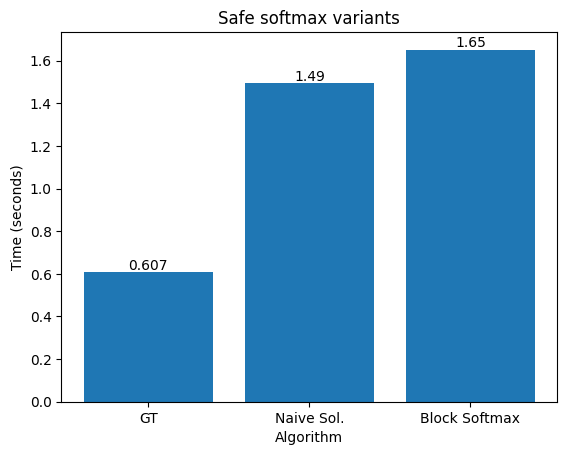

In [6]:
times = [gt_time, naive_time, block_time]
labels = ['GT', 'Naive Sol.', 'Block Softmax']

x = np.arange(len(times))
bars = plt.bar(x, times)

plt.title("Safe softmax variants")
plt.ylabel('Time (seconds)')
plt.xlabel('Algorithm')
plt.xticks(x, labels)

# Add numbers on top of bars (2 sig digits)
for bar, val in zip(bars, times):
    plt.text(
        bar.get_x() + bar.get_width() / 2,   # x-position (center of bar)
        bar.get_height(),                   # y-position (top of bar)
        f"{val:.3g}",                       # 2 sig digits
        ha='center', va='bottom'            # center align horizontally, above bar
    )

plt.show()